# Fit the light curve using the Simplest Transit Model
Fit the result with the parameters of exoplanets. 

## Simplest Transit Model
Assuming the gray atmosphere and Eddington Approximation, the limb darkening effect is a function of the only raidus. <br>
\begin{equation}
I(r) = I(0) \left( {2 \over 5} + {3 \over 5} \sqrt{1 - {r^2 \over R_*^2} } \right), 
\end{equation} 

\begin{equation}
F_{disk} = \int I(r) d\Omega = \int^{R_*}_{0} I(r) {{2\pi r} \over {d^2}} dr = {4\pi R_*^2 \over 5d^2} I(0), 
\end{equation}

If both of exoplanet and star are perfect spheres, the occultaion by exoplanet can be calculated by a part of ring as follows.<br>
<div><img src="transit_drawing.png" width=700></div>

There are two functions to simulate the transit event, and one demonstration. <br>
- **fdisk**: calculate the ratio of loss by the occultation 
- **light_curve**: calculate the variation of brightness over the time. 
- **plotting**: plot the demonstration by the radius of exoplanet 


In [1]:
import time, os
import numpy as np
import matplotlib.pyplot as plt 
from scipy.optimize import curve_fit
from photlib import read_params, prnlog

c:\Users\kang\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def fdisk(rx, rp):
    '''
    Calculate total flux of stellar disk when planet is located at x
     1. rx : position along the transit axis (x / Rs)
     2. rp : ratio of Rp to Rs (Rp / Rs) 
    '''
    def Ir(r):
        '''
        Limb-darkening for gray atmosphere and Eddington approx. 
        '''
        #logg = 4.5 Teff = 5750  ; 0.504 0.235 
        #return (1 - 0.504*(1-np.sqrt(1.0-r**2)) - 0.235*(1-np.sqrt(1.0-r**2)))    
        return (0.4 + 0.6*np.sqrt(1.0-r**2))    
    
    rx = np.abs(rx)
    # dr for stellar disk 
    dr = rp / 130.0
    # make r-array for each radius 
    r = np.arange(dr/2.0, 1.0, dr, dtype=np.float64)
    # make lambda-array for each radius
    lam = np.zeros(r.size, dtype=np.float64)
    
    # (case 1) |x / Rs| < Rp / Rs  (disk center - inside planet shadow) 
    if rx <= rp: 
        # r < rp + x (calculate lambda)
        v1 = np.where(r <= (rp+rx))[0]
        lam[v1] = np.arccos((rx**2 + r[v1]**2 - rp**2) / (2.0 * rx * r[v1]))
        # r < rp - x (lambda = pi, zero flux)
        v2 = np.where(r <= (rp-rx))[0]
        lam[v2] = np.pi
    # (case 2) |x / Rs| > Rp / Rs  (disk center - outside planet shadow)
    else:
        # if x-rp < r < x+rp 
        v1, = np.where((r >= (rx - rp)) & (r <= (rx + rp)))
        # then, calculate lambda(x, rp)  
        lam[v1] = np.arccos((rx**2 + r[v1]**2 - rp**2) / (2.0 * rx * r[v1]))

    # make flux-array for each radius (with lambda parameter)
    fr = Ir(r) * 2.0 * np.abs(np.pi - lam) * r * dr
    ftot = Ir(r) * 2.0 * np.pi * r * dr 
    
    return np.nansum(fr)/np.nansum(ftot)

In [3]:
def light_curve(x, *p):
    '''
    Generate the light curve
     0. ra2p: (a/Rs) / p = a/Rs(normalized semi-major axis) / period (day) 
     1. tc : the time of transit center (day)
     2. rp : (Rp/Rs) (normalized planetary radius) 
     3. rb : b (normalized impact parameter)
    '''
    ra2p, tc, rp, rb = p
    
    x = np.array(x, dtype=np.float64)
    
    # normalied time series ( t = 0 : middle of transit) 
    tt = x - tc
    # normalized velocity ( rx (= x / Rs) per day ) 
    tv = (2.0 * np.pi ) * ra2p #(ra / tp)
    # normalized tx (distance along the transit axis) 
    tx = tt * tv
    # normalized rx from the center of stellar disk (with impact parameter)
    ix = np.sqrt(tx**2 + rb**2)

    # make flux-array for each x-point
    tf = []
    for rx in ix:
        tf.append(fdisk(rx, rp))
    
    return np.array(tf,dtype=np.float64)

In [4]:
def plotting(rp=0.1, rb=0.0):
    import io, imageio, PIL 

    R, I0 = 500, 100
    pp, pb = R*rp, R*(1 - rb)

    lx = np.linspace(-1.5,1.5,91)
    ly = np.zeros(lx.size) 
    for i, rx in enumerate(lx):
        ly[i] = fdisk(np.sqrt(rb**2+rx**2), rp)
    
    plot_images = [] 
    for i in range(0,len(lx),10):
        rx = lx[i]
        px = rx*R + R + R/2.0
        
        img = np.zeros([2*R,3*R])
        ny, nx = img.shape
        yy, xx = np.indices(img.shape)
        rsq = (xx-(nx/2.0))**2 + (yy-(ny/2.0))**2
        vy, vx = np.where(rsq < R**2)
        img[vy, vx] = I0 * (0.4 + 0.6 * np.sqrt(1.0-rsq[vy, vx]/R**2))
        xsq = (xx-px)**2 + (yy-pb)**2
        vy, vx = np.where(xsq < pp**2)
        img[vy, vx] = I0*0.25 

        plt.figure(1,figsize=(7,7))
        ax1 = plt.axes([0.1, 0.28, 0.85, 0.70])
        ax1.axis('off')
        ax2 = plt.axes([0.1, 0.05, 0.85, 0.20])
        plt.title('rx = %.2f, rb = %.2f, rp = %.2f' % (rx, rb, rp))
        
        ax1.imshow(img, cmap='hot')
        ax1.plot([0,3*R],[pb, pb],'b--',lw=1)
        cx, cy = nx/2.0, ny/2.0
        ax1.set_xticks([cx-R, cx-0.5*R, cx, cx+0.5*R, cx+R])
        ax1.set_yticks([cy-R, cy-0.5*R, cy, cy+0.5*R, cy+R])
        ax1.set_xticklabels([-1,-0.5,0,0.5,1])
        ax1.set_yticklabels([-1,-0.5,0,0.5,1])
        ax1.set_xlim(0,nx)
        ax1.set_ylim(0,ny)

        ax2.plot(lx, ly, 'r-', linewidth=3, alpha=0.6)
        ax2.plot(rx, ly[i], 'ko', ms=10)
        dy = (1.0 - min(ly))*1.2
        ax2.set_ylim(1.0-dy, 1+dy*0.1)
        ax2.grid()
        img_buf = io.BytesIO()
        plt.savefig(img_buf, format='png')
        plot_images.append(PIL.Image.open(img_buf))
        plt.close('all')
    imageio.mimsave(f"transit_{rp*100:03.0f}_{rb*100:03.0f}.gif", plot_images)

In [5]:
plotting(rp=0.1, rb=0.5)

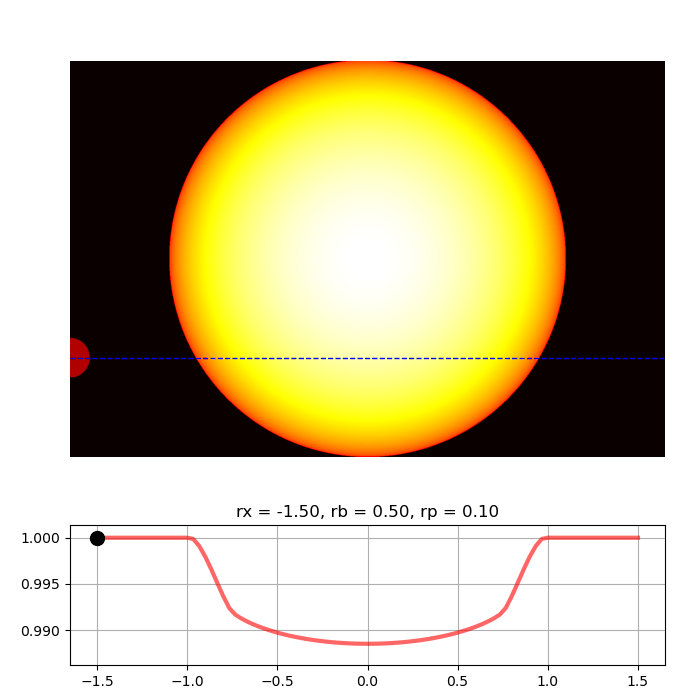

## Run Fitting 

Read the parameters inclulding the initial parameters for fitting from database of exoplanets (https://exoplanetarchive.ipac.caltech.edu/). <br>
You can get the recent parameters from the database, to run **read_nea.py**. <br>
Or you may input the fitting parameters in **tape.par** <br>
The first two are not fitting parameters, essential to estimate the radius [$R_{Jupiter}$] and semi-major axis [$au$] of exoplanet. 
- PER       5.0          # (FITTING)(INPUT) orbital period <br>
- RSTAR     1.0          # (FITTING)(INPUT) stellar radius in R_sun <br>
- A         0.05         # (FITTING)(INITIAL) semi-major axis in au <br>
- RR        0.1          # (FITTING)(INITIAL) planetary radius in R_star <br>
- B         0.1          # (FITTING)(INITIAL) impact parameter<br>


In [6]:
import time, os, shutil
import numpy as np
import matplotlib.pyplot as plt 
from scipy.optimize import curve_fit
from photlib import read_params, prnlog

# READ the parameters 
par = read_params()

WORKDIR = par['WORKDIR']
ODATE = par['OBSDATE']
PNAME = par['TARGETNAM']
FILTER = par['FILTER']

WORKNAME = 'w'+ODATE+'-'+PNAME+'-'+FILTER
DATAFILE = WORKNAME+'.dat'
DBFILE = 'nea.csv'

CONTCUT = np.array(par['CONTCUT'].split(','),float)
CONTCOEF = np.array(par['CONTCOEF'].split(','),float)
PER = float(par['PER'])
RSTAR = float(par['RSTAR'])
A, RR, B = float(par['A']), float(par['RR']), float(par['B'])
DMIN = float(par['DMIN'])
PLOTDESC = par['PLOTDESC']

# CHECK the parameters in database
dnames = np.genfromtxt(DBFILE, usecols=(0,), dtype='U', delimiter=',')
dpars = np.genfromtxt(DBFILE, usecols=(1,2,3,4,5), delimiter=',')
vv = np.where(dnames == PNAME)[0]
if len(vv) > 0:
    PER = dpars[vv[0],0]
    if ~np.isnan(dpars[vv[0],1]): RSTAR = dpars[vv[0],1]
    if ~np.isnan(dpars[vv[0],2]): A = dpars[vv[0],2]
    if ~np.isnan(dpars[vv[0],3]): RR = dpars[vv[0],3]
    if ~np.isnan(dpars[vv[0],4]): B = dpars[vv[0],4]

# PRINT the parameters 
prnlog("#WORK: fit_lightcurve")
prnlog(f"#DATA FILE: {DATAFILE}")
prnlog(f"#EXOPLANET DATA FILE: {DBFILE}")
prnlog(f"#PLANET NAME: {PNAME}")
prnlog(f"  PER={PER:.5f}")
prnlog(f"  RSTAR={RSTAR:.4f}")
prnlog(f"  A={A:.4f}")
prnlog(f"  RR={RR:.3f}")
prnlog(f"  B={B:.3f}")

# MOVE to the working directory =======
CDIR = os.path.abspath(os.path.curdir)
os.chdir(WORKDIR)
#======================================

#WORK: fit_lightcurve
#DATA FILE: w180326-HAT-P-12b-R.dat
#EXOPLANET DATA FILE: nea.csv
#PLANET NAME: HAT-P-12b
  PER=3.21306
  RSTAR=0.7000
  A=0.0384
  RR=0.138
  B=0.211


Normalize the light curve using polynomials. <br>
**local_continuum** is a function to normalize things such as transit light curve. <br>

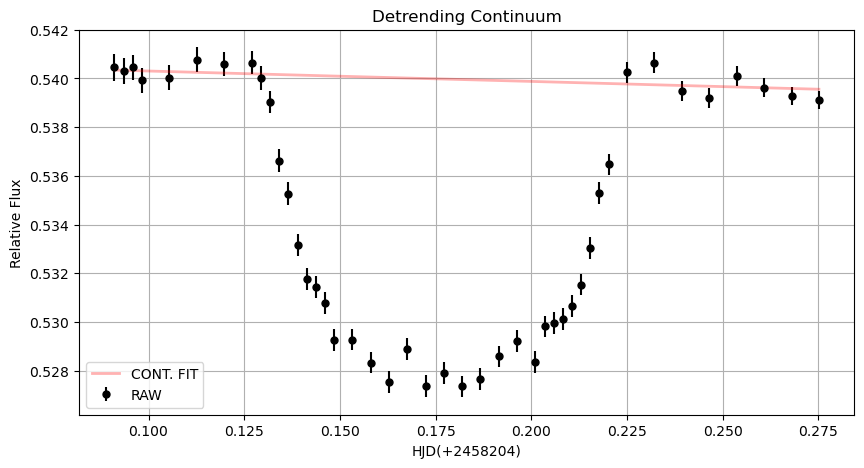

In [7]:

def local_continuum(xp, yp, p0=[1,0], cuts=[0.995,1.5]):
    '''
    determine local continuum of LC
    using polynomial functions 0th, 1st, 2nd, 3rd
    // limiting the coefficients 
    '''
    
    N_MAX=35
    #LIMITS = [30, 0.2, 0.2, 0.2]
    def fcont(x, *p):
        y = np.zeros_like(x)
        for i, param in enumerate(p):
            y = y + param * x**i
        return y
    lower, upper = cuts
    x0 = xp.mean() 
    xp = xp - x0
    xv, yv, coeff = xp, yp, p0
    for i in range(N_MAX):
        coeff, _ = curve_fit(fcont, xv, yv, p0=coeff)
        yc = fcont(xv, *coeff)
        yc_sig = np.std(yv - yc)
        # leave the first 5 pts and last 5 pts
        vv = np.where((yv > yc*lower) & (yv < yc*upper))[0]
        if (len(vv) < 15): break
        if (len(vv) == len(xv)): break
        xv, yv = xv[vv], yv[vv]
    #print (coeff)
    return fcont(xp, *coeff) 

tp, rp, rb = PER, RR, B
ra = (A / RSTAR) * 215.093991
dat = np.loadtxt(DATAFILE)
x1, y1, y1err = dat[:,0], dat[:,1], dat[:,2]#/0.998
x0 = int(x1[0])
x = x1 - x0

# NORMALIZE the light curve 
if len(CONTCOEF) == 1:
    y = y1 / CONTCOEF
    yerr = y1err / CONTCOEF
else:
    yfit = local_continuum(x,y1,p0=CONTCOEF,cuts=CONTCUT)
    y = y1 / yfit
    yerr = y1err / yfit 
    fig, ax0 = plt.subplots(figsize=(10,5))
    ax0.errorbar(x, y1, yerr=y1err, ms=5, fmt='ko',label='RAW')
    ax0.plot(x, yfit, 'r-', lw=2, alpha=0.3, label='CONT. FIT')
    ax0.set_xlabel(f'HJD(+{x0:d})')
    ax0.set_ylabel('Relative Flux')
    ax0.legend()
    ax0.grid()
    ax0.set_title('Detrending Continuum')
    fig.savefig(WORKNAME+'-DTR.png')

# WRITE detrending results to the text file
fbin = open(WORKNAME+'-NORM.txt', 'w')
for kx, ky, kerr in zip(x+x0, y, yerr):
    fbin.write(f"{kx:16.8f} {ky:12.8f} {kerr:12.8f}\n")
fbin.close()


Estimate the middle time of transit event. <br>

In [8]:
tc = np.sum(x*(1-y)**2) / np.sum((1-y)**2)
prnlog(f"INITIAL T_C = {tc+x0}")

INITIAL T_C = 2458204.178006693


Do binning the data with the interval of **DMIN** [min]. If **DMIN** is zero, it does not do binning. 

In [9]:
DMIN

0.0

In [10]:
if DMIN > 0: 
    dx = DMIN/(24*60.0)
    orx = np.arange(x.min(),x.max(),dx)
    rx, ry, ryerr = [], [], []
    for ix in orx:
        rr, = np.where((x >= ix-dx) & (x <= ix+dx))
        if len(rr) < 2: continue
        rx.append(ix)
        ry.append(np.mean(y[rr]))
        ryerr.append(np.std(y[rr]))
    rx, ry, ryerr = np.array(rx), np.array(ry), np.array(ryerr)
    # SAVE the binning data into the file 
    fbin = open(WORKNAME+'-DMIN%02i.txt' % (DMIN,), 'w')
    for kx, ky, kerr in zip(rx+x0, ry, ryerr):
        fbin.write(f"{kx:16.8f} {ky:12.8f} {kerr:12.8f}\n")
    fbin.close()
else:
    rx, ry, ryerr = x, y, yerr 

Fit the light curve by scipy.optimize.curve_fit

In [11]:
def fit_light_curve(rx, ry, ryerr, ra2p, tc, rp, rb, BOUND=0):    
    # FITTING with curve_fit    
    if BOUND:
        c, cov = curve_fit(light_curve, rx, ry, p0=[ra2p, tc, rp, rb],
                           sigma=ryerr, absolute_sigma=True, method='trf',
                           bounds=([0.5*ra2p,tc-0.05,0.5*rp,rb-0.3],
                                   [2.0*ra2p,tc+0.05,2.0*rp,rb+0.3]))     
    else:
        c, cov = curve_fit(light_curve, rx, ry, p0=[ra2p, tc, rp, rb],
                           sigma=ryerr, absolute_sigma=True)

    # CALC. the errors of fitting parameters 
    cerr = []
    for i in range(len(c)):
        try:
            cerr.append(np.absolute(cov[i][i])**0.5)
        except:
            cerr.append(0.0)

    return c, cerr

# RUN fitting of LC
c, cerr = fit_light_curve(rx, ry, ryerr, ra/tp, tc, rp, rb)        

Print the fitting results with errors 

In [12]:
# DEFINE the fitting parameters
c_ra2p, c_tc, c_rp, c_rb = c
c_ra2p_err, c_tc_err, c_rp_err, c_rb_err = cerr
# CALC. the params and errors 
c_rb = np.abs(c_rb)        
incl = 90 - np.arcsin(c_rb / (c_ra2p * PER)) * 180 / np.pi
incl_errsq = (c_rb_err / c_ra2p)**2 + \
                (c_ra2p_err * c_rb/(c_ra2p**2))**2
incl_err = 180*np.pi*np.sqrt(incl_errsq/(1-(c_rb/(c_ra2p*PER))**2))/PER
c_a = (c_ra2p * PER) * RSTAR / 215.093991
c_a_err = (c_ra2p_err * PER) * RSTAR / 215.093991
c_p = c_rp * RSTAR / 0.10045
c_p_err = c_rp_err * RSTAR / 0.10045
# PRINT the results 
prnlog('INPUTS-------------')
prnlog(f"Tc = {x0+tc:.5f}")
prnlog(f"Rp = {RR * RSTAR / 0.10045}")
prnlog(f"a = {A}")
prnlog(f"b = {B}")
prnlog('OUTPUTS------------')
prnlog(f"Tc = {x0+c_tc:.5f} ({c_tc_err:.5f})")
prnlog(f"Rp/Rs = {c_rp:.3f} ({c_rp_err:.3f})")
prnlog(f"Rp = {c_p:.2f} ({c_p_err:.2f})")
prnlog(f"a/Rs = {c_ra2p*tp:.4f}, ({c_ra2p_err*tp:.4f})")
prnlog(f"a = {c_a:.5f} ({c_a_err:.5f})")
prnlog(f"b = {c_rb:.2f} ({c_rb_err:.2f})")
prnlog(f"i = {incl:.1f} ({incl_err:.1f})")

INPUTS-------------
Tc = 2458204.17801
Rp = 0.9590000000000001
a = 0.0384
b = 0.211
OUTPUTS------------
Tc = 2458204.17699 (0.00019)
Rp/Rs = 0.135 (0.001)
Rp = 0.94 (0.01)
a/Rs = 11.8998, (0.1276)
a = 0.03873 (0.00042)
b = 0.19 (0.03)
i = 89.1 (1.3)


Plot the light curve with fitting results.

(0.09107217006385326, 0.2751566502265632)

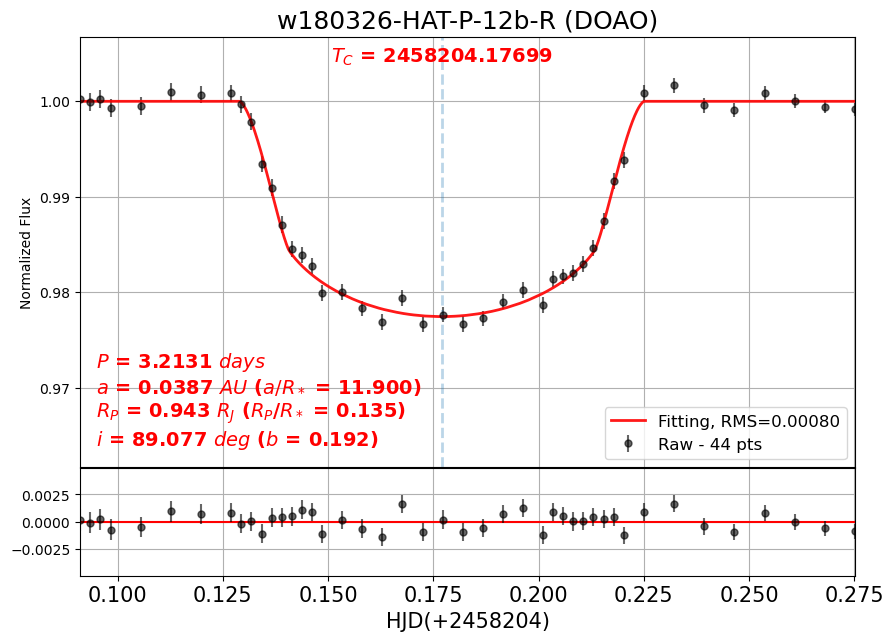

In [13]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10,7), sharex=True, gridspec_kw={'height_ratios':[4,1]})
fig.subplots_adjust(hspace=0.003)
    
# CALC. fitting RMS
y2 = light_curve(x, *c)
ry2 = light_curve(rx, *c)
rms = np.sqrt(np.mean((ry-ry2)**2))
if DMIN > 0:
    ax1.plot(x, y, 'k+', mew=1, ms=5, label='Raw - %d pts' % (len(x),), alpha=0.5)
    ax1.errorbar(rx,ry,yerr=ryerr,ms=5,fmt='bo',ecolor='b',alpha=0.6, label='Avg in %i min.' % (DMIN,))
else:
    ax1.errorbar(rx,ry,yerr=ryerr,ms=5,fmt='ko',ecolor='k',alpha=0.6, label='Raw - %d pts' % (len(x),))
# PLOT fitting result 
xfit = np.linspace(np.min(rx),np.max(rx),1000)
yfit = light_curve(xfit, *c)
ax1.plot(xfit, yfit, 'r-', linewidth=2, alpha=0.9, label='Fitting, RMS=%.5f' % (rms,))
# show the parameters of planet
dry = (1 - yfit.min())
ymax = 1 + dry * 0.3
ymin = 1 - dry * 1.7

ax1.plot([c_tc,c_tc],[ymin, ymax], '--', lw=2, alpha=0.3)
desc = '''$P$ = %.4f $days$ 
$a$ = %.4f $AU$ ($a/R_*$ = %.3f)
$R_P$ = %.3f $R_J$ ($R_P$/$R_*$ = %.3f)
$i$ = %.3f $deg$ ($b$ = %.3f)'''           
desc = desc % (PER, c_a, c_ra2p*tp, c_p, c_rp, incl, c_rb)
ax1.text(0.02, 0.05, desc, fontsize=14, transform=ax1.transAxes, fontweight='bold', color='r', alpha=1)
ax1.text(c_tc, ymax-0.001, '$T_C$ = %.5f' % (c_tc+x0,), fontsize=14, color='r', fontweight='bold',
            va='top', ha='center')
ax1.legend(loc='lower right',fontsize=12)
ax1.grid()
ax1.set_ylim(ymin, ymax)
ax1.set_xlim(x.min(), x.max()) 
ax1.set_ylabel('Normalized Flux') 
ax1.set_title(WORKNAME+' ('+PLOTDESC+')', fontsize=18)

ax2.plot([x.min(), x.max()], [0,0], 'r-')
if DMIN > 0:
    ax2.plot(x, y-y2, 'k+', mew=1, ms=5, alpha=0.5)
    ax2.errorbar(rx,ry-ry2,yerr=ryerr,ms=5,fmt='bo',ecolor='b',alpha=0.6)
else:
    ax2.errorbar(rx,ry-ry2,yerr=ryerr,ms=5,fmt='ko',ecolor='k',alpha=0.6)
ax2.set_xlabel('HJD(+%i)' % (x0,), fontsize=15)
ax2.tick_params(axis='x', labelsize=15)
ax2.tick_params(axis='y', labelsize=10)
ax2.grid()
ax2.set_ylim(-0.0049,0.0049)
ax1.set_xlim(x.min(), x.max()) 


Return to the directory

In [14]:
# ====================================
os.chdir(CDIR) # RETURN
# ====================================